In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
####Data Preprocessing###
###Convert Image to np Array###
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
!pip install ndjson

In [ ]:
def image_to_array(image_path):
    image=Image.open(image_path)
    resized_image=image.resize((64,64),Image.LANCZOS)
    input=np.array(resized_image)
    input=np.expand_dims(input,axis=0)
    reshaped_image=input.reshape(1,64,64,3)
    return reshaped_image.tolist()

In [ ]:
import json
import ndjson

def retrive_data_from_json(file_name):
    with open(file_name,"r") as json_processed_file:
        json_processed_data=ndjson.load(json_processed_file)
    return json_processed_data

In [ ]:
json_processed_data=retrive_data_from_json("/content/drive/MyDrive/OilSpill_Project/DataSet/data_processed_full.json")

In [ ]:
###Data Loader

def train_test_split(json_processed_data):
    overall_samples=len(json_processed_data)
    test_samples=overall_samples//5
    train_samples=overall_samples-test_samples

    x_train_data=np.empty((train_samples,*(32,32,3)))
    y_train_data=np.empty((train_samples,),dtype='uint8')
    x_test_data=np.empty((test_samples,*(32,32,3)))
    y_test_data=np.empty((test_samples,),dtype='uint8')

    for idx in range(train_samples):
        image_data_points=json_processed_data[idx].get('image')[0]
        image_type=json_processed_data[idx].get('type')
        org_img=Image.fromarray(np.squeeze(np.array(image_data_points).astype(np.uint8)))
        resized_image=org_img.resize((32,32),Image.LANCZOS)
        x_train_data[idx]=resized_image
        y_train_data[idx]=image_type


    for counter,idx in zip(range(test_samples),range(train_samples,overall_samples)):
        image_data_points=json_processed_data[idx].get('image')[0]
        image_type=json_processed_data[idx].get('type')
        org_img=Image.fromarray(np.squeeze(np.array(image_data_points).astype(np.uint8)))
        resized_image=org_img.resize((32,32),Image.LANCZOS)
        x_test_data[counter]=resized_image
        y_test_data[counter]=image_type

    y_train_data=y_train_data.reshape(train_samples,1)
    y_test_data=y_test_data.reshape(test_samples,1)

    return (x_train_data,y_train_data),(x_test_data,y_test_data)

In [ ]:
###Calling test train function
(x_train_data,y_train_data),(x_test_data,y_test_data)=train_test_split(json_processed_data)

In [ ]:
###Tensorflow Model

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model


def start_training(model,save_dir):
    # Compile
    checkpoint_path = "/content/drive/MyDrive/Oil Spill model/CheckPoints/"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=False) ##To save checkpoints in Epoch

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    # Fit
    r = model.fit(
    x_train_data, y_train_data, validation_data=(x_test_data, y_test_data), epochs=50, batch_size=1, callbacks=[cp_callback])


###loading json file and getting tupple of train and test data with image
####Overfit json data split to train and test###


def create_model(x_train_data,y_train_data):
    no_of_classes=len(set(y_train_data))

    ##Model- Starts
    ###Input Layer
    i = Input(shape=x_train_data[0].shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.2)(x)

    # Hidden layer
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.2)(x)

    # last hidden layer i.e.. output layer
    x = Dense(no_of_classes, activation='softmax')(x)

    model = Model(i, x)

    # model description
    model.summary()
    return model

In [ ]:
####Reducing pixel values
# x_train_data,x_test_data=x_train_data/255.0,x_test_data/255.0
##Flatten the image
y_train_data,y_test_data=y_train_data.flatten(),y_test_data.flatten()

model=create_model(x_train_data,y_train_data)

model_save_dir="/content/drive/MyDrive/Oil Spill model/oilspill_model_full.h5" ##should be h5 Ext

start_training(model,model_save_dir)
model.save(model_save_dir)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 32)        0   

1/1 [==============================] - 0s 370ms/step
Oil spill Present


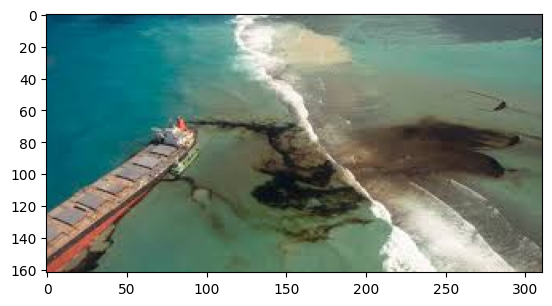

In [ ]:
 ###Evaluation

###Evaluation from image

###OilSpill -0
###NonOilSpill -1
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
pre_trained_model=load_model("/content/drive/MyDrive/Oil Spill model/oilspill_model_full.h5")

from PIL import Image
image=Image.open("/content/drive/MyDrive/Oil Spill model/Validation/os1.jpg")
plt.imshow(image)
resized_image=image.resize((32,32),Image.LANCZOS)
input=np.array(resized_image)

input=np.expand_dims(input,axis=0)

reshaped_image=input.reshape(1,32,32,3)

pred=pre_trained_model.predict(reshaped_image).argmax()

##print(pred)

if pred==0:
  print("Oil spill Present")
else:
  print("Oil spill does not present")

1/1 [==============================] - 0s 465ms/step
Oil spill does not present


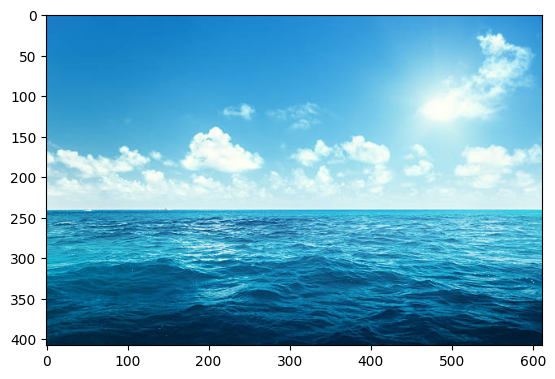

In [ ]:
 ###Evaluation

###Evaluation from image

###OilSpill -0
###NonOilSpill -1
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
pre_trained_model=load_model("/content/drive/MyDrive/Oil Spill model/oilspill_model_full.h5")

from PIL import Image
image=Image.open("/content/drive/MyDrive/Oil Spill model/Validation/nos.jpg")
plt.imshow(image)
resized_image=image.resize((32,32),Image.LANCZOS)
input=np.array(resized_image)

input=np.expand_dims(input,axis=0)

reshaped_image=input.reshape(1,32,32,3)

pred=pre_trained_model.predict(reshaped_image).argmax()

##print(pred)

if pred==0:
  print("Oil spill Present")
else:
  print("Oil spill does not present")

1/1 [==============================] - 0s 205ms/step
Oil spill does not present


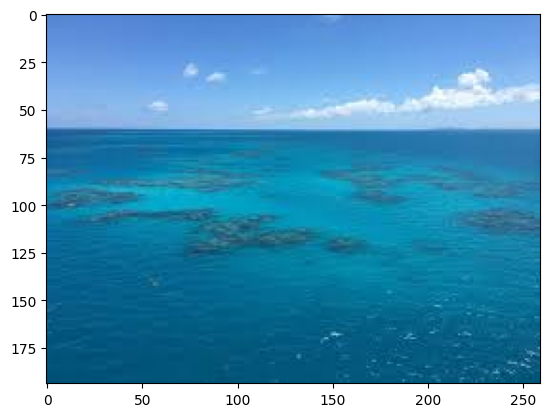

In [ ]:
 ###Evaluation

###Evaluation from image

###OilSpill -0
###NonOilSpill -1
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
pre_trained_model=load_model("/content/drive/MyDrive/Oil Spill model/oilspill_model_full.h5")

from PIL import Image
image=Image.open("/content/drive/MyDrive/Oil Spill model/Validation/i.jpg")
plt.imshow(image)
resized_image=image.resize((32,32),Image.LANCZOS)
input=np.array(resized_image)

input=np.expand_dims(input,axis=0)

reshaped_image=input.reshape(1,32,32,3)

pred=pre_trained_model.predict(reshaped_image).argmax()

##print(pred)

if pred==0:
  print("Oil spill Present")
else:
  print("Oil spill does not present")